### 1. Packages

In [1]:
!pip install rouge
!pip install rouge_score
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=c9d8a556a0cfd5beaf595b1a306f767602ba1ac54d5584d1483f52ea3a9da515
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge_score
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#Libraries
import os
import pandas as pd
import xml.etree.ElementTree as ET
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict
import re
import numpy as np
from pprint import pprint
from rouge import Rouge
from nltk.cluster.util import cosine_distance
from tqdm import tqdm
import evaluate


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Importing Dataset

In [5]:
folder = '/content/drive/MyDrive/NLP Project/case_files'
folder_clean = '/content/drive/MyDrive/NLP Project/case_files_clean'

folder2 = '/content/drive/MyDrive/NLP Project/case_files_citations_summ'
folder_clean2 = '/content/drive/MyDrive/NLP Project/case_files_citations_summ_clean'

pick_files = 100

data = []
for filename in os.listdir(folder):
    if filename.endswith('.xml'):
        fullname = os.path.join(folder, filename)
        fullname2= os.path.join(folder_clean, filename)
        #print(fullname)
        # Open the XML file as a text file
        with open(fullname, 'r') as f:
            xml_text = f.read()

        # Replace the catchphrase "id=" with "catchphrase id="
        xml_text = xml_text.replace('catchphrase "id=', 'catchphrase id="')
        xml_text = xml_text.replace('&', '')

        # Write the modified XML back to the file
        with open(fullname2, 'w') as f:
            f.write(xml_text)
            
        tree = ET.parse(fullname2)
        root = tree.getroot()
        case_name = root.find('name').text
        austlii = root.find('AustLII').text
        catchphrases = [cp.text for cp in root.find('catchphrases').findall('catchphrase')]
        sentences = [s.text for s in root.find('sentences').findall('sentence')]
        data.append((case_name, austlii, catchphrases, sentences))
        #print("Done")
        if pick_files == 0:
          break
        pick_files=pick_files -1
        
df1 = pd.DataFrame(data, columns=['case_name', 'austlii', 'catchphrases', 'sentences'])
print("Dataframe created with shape ",df1.shape)    

data2 = []

pick_files = 100

for filename in os.listdir(folder2):
    if filename.endswith('.xml'):
        fullname = os.path.join(folder2, filename)
        fullname2= os.path.join(folder_clean2, filename)
        #print(fullname)
        # Open the XML file as a text file
        with open(fullname, 'r') as f:
            xml_text = f.read()
        
        # Replace the catchphrase "id=" with "catchphrase id="
        #xml_text = xml_text.replace('id=', '')
        
        xml_text = xml_text.replace('&','')
        xml_text = xml_text.replace('type=cited','type="cited"')
        xml_text = xml_text.replace('type=citing','type="citing"')
        
        # Write the modified XML back to the file
        with open(fullname2, 'w') as f:
            f.write(xml_text)
            
        tree = ET.parse(fullname2)
        
        root = tree.getroot()
        case_name = root.find('name').text
        austlii = root.find('AustLII').text
        citphrases = [cp.text for cp in root.find('citphrases').findall('citphrase') if cp.attrib['type'] == 'cited']
        #citphrases = [cp.text for cp in root.find('citphrases').findall('citphrase') if cp.get('type') == 'cited']
        if citphrases != []:
            data2.append((case_name, austlii, citphrases))
        
        if pick_files == 0:
          break
        pick_files=pick_files -1
        
df2 = pd.DataFrame(data2, columns=['case_name', 'austlii', 'citphrases'])
print("Dataframe created with shape ",df2.shape)  

merged_df = pd.merge(df1, df2, on=['case_name', 'austlii'], how='inner')

# print the counts of rows in each dataframe and the merged dataframe
print("Number of rows in df1:", len(df1))
print("Number of rows in df2:", len(df2))
print("Number of rows in merged_df:", len(merged_df))

Dataframe created with shape  (101, 4)
Dataframe created with shape  (85, 3)
Number of rows in df1: 101
Number of rows in df2: 85
Number of rows in merged_df: 79


In [6]:
merged_df.head()

,case_name,austlii,catchphrases,sentences,citphrases
0,Shaheed v Tax Agents' Board of New South Wales...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[appeal from administrative appeals tribunal, ...",[\n \n\n \n1 This is an appeal under s 44 of t...,"[administrative law, appeal from decision of a..."
1,CMG Equity Investments Pty Ltd v Australia and...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[contract to lend shares, rectification, right...",[\n \n\n1 The worldwide stock market collapse ...,"[real property (n.s.w.), torrens system, prior..."
2,SZHTC v Minister for Immigration amp; Citizens...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[appeal from decision of federal magistrate, a...",[\n \n1 This is an appeal from a judgment of a...,"[migration, procedural fairness, whether the t..."
3,Drew v Dibb [2008] FCA 1057 (17 July 2008),http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[customs duties, when obligation incurred, obl...",[\n \n1 The respondents hold a licence issued ...,"[customs, imported goods, non-entry of goods f..."
4,National Union of Workers v Coles CDC Eastern ...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[meaning and effect of s 322 of the act, wheth...",[\n The primary issues\n The primary issues fo...,"[taxation, income tax, whether losses carried ..."


In [7]:
df=merged_df.sample(frac=0.6, random_state=42, ignore_index = True)
df.head()

,case_name,austlii,catchphrases,sentences,citphrases
0,Xat Ky v Australvic Property Management Pty Lt...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[costs orders against a non-party, discretion ...",[\n \n1 Upon ordering the winding up of Austra...,"[practice, costs, award jurisdiction against n..."
1,Shaheed v Tax Agents' Board of New South Wales...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[appeal from administrative appeals tribunal, ...",[\n \n\n \n1 This is an appeal under s 44 of t...,"[administrative law, appeal from decision of a..."
2,Memcor Australia Pty Ltd v G E Betzdearborn Ca...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[patents, divisional application, whether divi...",[\n THE ISSUE \n The issue in this appeal is w...,"[intellectual property, patents, claims, const..."
3,Croker v Commonwealth of Australia [2008] FCA ...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[consumer protection, claim for damages, appli...",[\n (REVISED FROM THE TRANSCRIPT) \n \n1 This ...,"[trade practices, consumer protection, claim f..."
4,Australian Tea Tree Oil Research Institute Ltd...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,[whether companies undertaking scientific rese...,[\n INTRODUCTION \n \n1 These are two sets of ...,"[income tax, management fee income discharged ..."


In [8]:
#Creating Duplicate columns
df['catchphrases_duplicate'] = df.loc[:, 'catchphrases']
df['citphrases_duplicate'] = df.loc[:, 'citphrases']

In [9]:
#Shape of Dataframe
print("Dataframe created with shape ",df.shape)

Dataframe created with shape  (47, 7)


In [10]:
#Example dataframe
df.head()

,case_name,austlii,catchphrases,sentences,citphrases,catchphrases_duplicate,citphrases_duplicate
0,Xat Ky v Australvic Property Management Pty Lt...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[costs orders against a non-party, discretion ...",[\n \n1 Upon ordering the winding up of Austra...,"[practice, costs, award jurisdiction against n...","[costs orders against a non-party, discretion ...","[practice, costs, award jurisdiction against n..."
1,Shaheed v Tax Agents' Board of New South Wales...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[appeal from administrative appeals tribunal, ...",[\n \n\n \n1 This is an appeal under s 44 of t...,"[administrative law, appeal from decision of a...","[appeal from administrative appeals tribunal, ...","[administrative law, appeal from decision of a..."
2,Memcor Australia Pty Ltd v G E Betzdearborn Ca...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[patents, divisional application, whether divi...",[\n THE ISSUE \n The issue in this appeal is w...,"[intellectual property, patents, claims, const...","[patents, divisional application, whether divi...","[intellectual property, patents, claims, const..."
3,Croker v Commonwealth of Australia [2008] FCA ...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[consumer protection, claim for damages, appli...",[\n (REVISED FROM THE TRANSCRIPT) \n \n1 This ...,"[trade practices, consumer protection, claim f...","[consumer protection, claim for damages, appli...","[trade practices, consumer protection, claim f..."
4,Australian Tea Tree Oil Research Institute Ltd...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,[whether companies undertaking scientific rese...,[\n INTRODUCTION \n \n1 These are two sets of ...,"[income tax, management fee income discharged ...",[whether companies undertaking scientific rese...,"[income tax, management fee income discharged ..."


In [11]:
df['catchphrases'][0]

['costs orders against a non-party',
 'discretion to award indemnity costs',
 'entitlement of asic as an intervener to costs orders',
 'costs']

In [12]:
df['citphrases'][0]

['practice',
 'costs',
 'award jurisdiction against non-party',
 'receiver and manager conducting litigation through insolvent company',
 'supreme court act 1867 (q), s. 58',
 'rules of the supreme court of queensland o. 91, r.1.',
 'practice and procedure',
 'costs',
 'discretion of the court',
 "award on solicitor and client' or indemnity' basis",
 'whether application vexatious',
 'form of order.']

### 3. Data Cleaning

In [13]:
import timeit

In [14]:
def clean_strings(strings):
    cleaned_strings = []
    pattern = r'[^a-zA-Z\s]'
    pattern2 = r'\s+'
    #pattern = r'[^a-zA-Z0-9.\s]|(?<=\d)[.]|\b[a-zA-Z]{1,3}\b'

    #pattern = re.compile(r"[^a-zA-Z]+")
    

    for string in strings:
        result1 = re.sub(pattern2, ' ', string)
        result2 = re.sub(pattern, ' ', result1)
        cleaned_string = re.sub(pattern2, ' ', result2)
        #cleaned_string = pattern.sub(" ", string)
        cleaned_strings.append(cleaned_string)
    return cleaned_strings

In [15]:
df['catchphrases']= df['catchphrases'].apply(clean_strings)
df['citphrases']= df['citphrases'].apply(clean_strings)

### 4. SumBasic Algorithm

In [16]:
#Word Frequency Calculator
def calculate_word_frequency(document):
    word_freq = defaultdict(int)
    for word in word_tokenize(document):
        #print(word)
        word_freq[word.lower()] += 1
    return word_freq

In [17]:
#Sentence Score Calculator
def calculate_sentence_scores(sentences, word_freq):
    sentence_scores = defaultdict(int)
    for sentence in sentences:
        #print(sentence)
        for word in word_tokenize(sentence.lower()):
            #print(word)
            if word in word_freq:
                #print(word_freq[word])
                sentence_scores[sentence] += word_freq[word]
        sentence_scores[sentence] /= len(word_tokenize(sentence.lower()))
    return sentence_scores

In [18]:
#Sumary Creator
def sumbasic_summarize(document, length):
    sentences = sent_tokenize(document)
    #print(1,sentences)
    word_freq = calculate_word_frequency(document)
    #print(2,word_freq)
    sentence_scores = calculate_sentence_scores(sentences, word_freq)
    summary = ''
    while length > 0:
        summary += max(sentence_scores, key=sentence_scores.get) + ' '
        sentence_scores.pop(max(sentence_scores, key=sentence_scores.get))
        length -= 1
    return summary

In [21]:
#Columns with Summary
df['num_words'] = None
df['num_unique_words'] = None
df['num_citphrases'] = None
df['catchphrases_summary'] = None
df['sumbasic_citphrases_summary'] = None

In [22]:
#Saving given catchphrase summary, and created summary
df['sumbasic_citphrases_time']=None
for i in range(df.shape[0]):
#for i in [1]:
    
    

    catchphrases_summary = ". ".join(df['catchphrases'][i])
    catchphrases_summary = catchphrases_summary + "."
    df['catchphrases_summary'][i] = catchphrases_summary.lower()
    #print(catchphrases_summary, "\n")
    num_sentences = len(df['catchphrases'][i])

    num_citphrases = len(df['citphrases'][i])
    df['num_citphrases'][i] = num_citphrases
    
    document = ". ".join(df['citphrases'][i])
    document = document +'.'
    #print(document, "\n")

    start = timeit.default_timer()
    document_summary = sumbasic_summarize(document.lower(), num_sentences)
    stop = timeit.default_timer()
    time_diff=(round((stop - start),2))
    df['sumbasic_citphrases_time'][i]=time_diff

    
    df['sumbasic_citphrases_summary'][i] = document_summary
    #print(catchphrases_summary, "\n", document_summary)
    
    word_freq = calculate_word_frequency(document)
    
    df['num_words'][i]=sum(list(word_freq.values()))
    
    df['num_unique_words'][i]=len(list(word_freq.values()))


In [23]:
#Printing Summary for 10 cases
for i in range(df.shape[0]):
    print(len(df['catchphrases'][i]),"\n", df['catchphrases_summary'][i], "\n", df['sumbasic_citphrases_summary'][i])

    if i==10:
      break

4 
 costs orders against a non party. discretion to award indemnity costs. entitlement of asic as an intervener to costs orders. costs. 
 costs. practice. practice and procedure. form of order . 
7 
 appeal from administrative appeals tribunal. meaning of fit and proper person to prepare tax returns . whether tribunal misconstrued meaning of fit and proper . whether tribunal failed to have regard to the test in briginshaw v briginshaw hca clr . whether the tribunal took into account irrelevant considerations. whether decision of tribunal otherwise unreasonable . administrative law. 
 administrative law. auditors. grounds. ambit. functions. validity. judicial review. 
4 
 patents. divisional application. whether divisional application within the scope of the claims in the parent application. intellectual property. 
 patents. validity. novelty. infringement. 
9 
 consumer protection. claim for damages. application for leave to extend time in which applicant could seek leave to file appli

### 5. KL Divergence Algorithm

In [24]:
#Word Frequency Calculator
def calculate_word_frequency(document):
    word_freq = defaultdict(int)
    for word in word_tokenize(document):
        #print(word)
        word_freq[word.lower()] += 1
    return word_freq

In [25]:
#Word Distribution Calculator
def calculate_word_distribution(word_freq):
    total_words = sum(word_freq.values())
    word_dist = {word: freq / total_words for word, freq in word_freq.items()}
    return word_dist

In [26]:
#Sentence Score Calculator
def calculate_sentence_scores(sentences, word_freq, word_dist):
    sentence_scores = defaultdict(int)
    for sentence in sentences:
        sentence_word_freq = defaultdict(int)
        for word in word_tokenize(sentence.lower()):
            sentence_word_freq[word] += 1
        sentence_word_dist = {word: freq / len(word_tokenize(sentence.lower())) for word, freq in sentence_word_freq.items()}
        kl_divergence = sum(sentence_word_dist[word] * np.log(sentence_word_dist[word] / word_dist.get(word, 1e-12)) for word in sentence_word_dist)
        sentence_scores[sentence] = kl_divergence
    return sentence_scores

In [27]:
#Summary Creator
def klsum_summarize(document, length):
    sentences = sent_tokenize(document)
    word_freq = calculate_word_frequency(document)
    word_dist = calculate_word_distribution(word_freq)
    sentence_scores = calculate_sentence_scores(sentences, word_freq, word_dist)
    summary = ''
    while length > 0:
        summary += max(sentence_scores, key=sentence_scores.get) + ' '
        sentence_scores.pop(max(sentence_scores, key=sentence_scores.get))
        length -= 1
    return summary

In [28]:
#Columns with Summary
df['kl_div_citphrases_summary'] = None
df['kl_div_citphrases_time']=None

In [29]:
#Saving given catchphrase summary, and created summary
for i in range(df.shape[0]):
    num_sentences = len(df['catchphrases'][i])
    document = ". ".join(df['citphrases'][i])
    #print(num_sentences, "\n")
    document = document +'.'
    start = timeit.default_timer()
    document_summary = klsum_summarize(document.lower(), num_sentences)
    stop = timeit.default_timer()
    time_diff=(round((stop - start),2))
    df['kl_div_citphrases_time'][i]=time_diff
    df['kl_div_citphrases_summary'][i] = document_summary
    #print(df['catchphrases_summary'][i], "\n", document_summary)

In [30]:
#Printing Summary for 10 cases
for i in range(df.shape[0]):
    print(len(df['catchphrases'][i]),"\n", df['catchphrases_summary'][i], "\n", df['kl_div_citphrases_summary'][i])
    if i==10:
      break


4 
 costs orders against a non party. discretion to award indemnity costs. entitlement of asic as an intervener to costs orders. costs. 
 whether application vexatious. practice. costs. award jurisdiction against non party. 
7 
 appeal from administrative appeals tribunal. meaning of fit and proper person to prepare tax returns . whether tribunal misconstrued meaning of fit and proper . whether tribunal failed to have regard to the test in briginshaw v briginshaw hca clr . whether the tribunal took into account irrelevant considerations. whether decision of tribunal otherwise unreasonable . administrative law. 
 discretionary judgments. workcover insurance. commercial broadcasting licences. ambit. functions. validity. practice and procedure. 
4 
 patents. divisional application. whether divisional application within the scope of the claims in the parent application. intellectual property. 
 road safety barriers. false suggestion. multi hull seagoing vessels. common general knowledge at

### 6. Textrank

In [31]:
MULTIPLE_WHITESPACE_PATTERN = re.compile(r"\s+", re.UNICODE)

In [32]:
def normalize_whitespace(text):
    """
    Translates multiple whitespace into single space character.
    If there is at least one new line character chunk is replaced
    by single LF (Unix new line) character.
    """
    return text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\f', ' ').replace('\v', ' ').strip()

In [33]:
def _replace_whitespace(match):
    text = match.group()

    if "\n" in text or "\r" in text:
        return "\n"
    else:
        return " "

In [34]:
def is_blank(string):
    """
    Returns `True` if string contains only white-space characters
    or is empty. Otherwise `False` is returned.
    """
    return not string or string.isspace()

In [35]:
def get_symmetric_matrix(matrix):
    """
    Get Symmetric matrix
    :param matrix:
    :return: matrix
    """
    return matrix + matrix.T - np.diag(matrix.diagonal())


In [36]:
def core_cosine_similarity(vector1, vector2):
    """
    measure cosine similarity between two vectors
    :param vector1:
    :param vector2:
    :return: 0 < cosine similarity value < 1
    """
    return 1 - cosine_distance(vector1, vector2)

In [37]:
class TextRank4Sentences():

    def __init__(self):
        self.damping = 0.85  # damping coefficient, usually is .85
        self.min_diff = 1e-5  # convergence threshold
        self.steps = 100  # iteration steps
        self.text_str = []  # list of documents
        self.sentences = []  # list of sentences
        self.pr_vector = None

    def _sentence_similarity(self, sent1, sent2, stopwords=None):
        if stopwords is None:
            stopwords = []

        sent1 = [w.lower() for w in sent1]
        sent2 = [w.lower() for w in sent2]

        all_words = list(set(sent1 + sent2))

        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)

        # build the vector for the first sentence
        for w in sent1:
            if w in stopwords:
                continue
            vector1[all_words.index(w)] += 1

        # build the vector for the second sentence
        for w in sent2:
            if w in stopwords:
                continue
            vector2[all_words.index(w)] += 1

        return core_cosine_similarity(vector1, vector2)

    def _build_similarity_matrix(self, sentences, stopwords=None):
        # create an empty similarity matrix
        sm = np.zeros([len(sentences), len(sentences)])

        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1 == idx2:
                    continue

                sm[idx1][idx2] = self._sentence_similarity(sentences[idx1], sentences[idx2], stopwords=stopwords)

        # Get Symmeric matrix
        sm = get_symmetric_matrix(sm)

        # Normalize matrix by column
        norm = np.sum(sm, axis=0)
        sm_norm = np.divide(sm, norm, where=norm != 0)  # this is to ignore the 0 element in norm

        return sm_norm

    def _run_page_rank(self, similarity_matrix):

        pr_vector = np.array([1] * len(similarity_matrix))

        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr_vector = (1 - self.damping) + self.damping * np.matmul(similarity_matrix, pr_vector)
            if abs(previous_pr - sum(pr_vector)) < self.min_diff:
                break
            else:
                previous_pr = sum(pr_vector)

        return pr_vector

    def _get_sentence(self, index):

        try:
            return self.sentences[index]
        except IndexError:
            return ""

    def get_top_sentences(self, number=2):

        top_sentences = {}

        if self.pr_vector is not None:

            sorted_pr = np.argsort(self.pr_vector)
            sorted_pr = list(sorted_pr)
            sorted_pr.reverse()

            index = 0
            for epoch in range(number):
                #print (str(sorted_pr[index]) + " : " + str(self.pr_vector[sorted_pr[index]]))
                sent = self.sentences[sorted_pr[index]]
                sent = normalize_whitespace(sent)
                top_sentences[sent] = self.pr_vector[sorted_pr[index]]
                index += 1

        return top_sentences

    def analyze(self, text, stop_words=None):
        self.text_str = text
        self.sentences = sent_tokenize(self.text_str)
        
        tokenized_sentences = [word_tokenize(sent) for sent in self.sentences]
        
        similarity_matrix = self._build_similarity_matrix(tokenized_sentences, stop_words)
        
        self.pr_vector = self._run_page_rank(similarity_matrix)
        #print(self.pr_vector)


In [38]:
#Columns with Textrank Summary
df['textrank_citphrases_summary'] = None
df['textrank_citphrases_time']=None

In [39]:
#Saving given catchphrase summary, and created summary
for i in range(df.shape[0]):
    
    num_sentences = len(df['catchphrases'][i])
    tr4s = TextRank4Sentences()
    document = ". ".join(df['citphrases'][i])
    document = document +'.'
    #print(document)
    start = timeit.default_timer()
    tr4s.analyze(document)
    stop = timeit.default_timer()
    time_diff=(round((stop - start),2))
    df['textrank_citphrases_time'][i]=time_diff
    
    document_summary = tr4s.get_top_sentences(num_sentences)
    document_summary = ' '.join(document_summary.keys())

    #print(document_summary)

    df['textrank_citphrases_summary'][i] = document_summary
    #print(df['catchphrases_summary'][i], "\n", document_summary)

In [40]:
for i in range(df.shape[0]): 
    print(len(df['catchphrases'][i]))   
    print("Catchphrase Summary : ", df['catchphrases_summary'][i])
    print("sumbasic_citphrases Summary : ", df['sumbasic_citphrases_summary'][i])
    print("kl_div_citphrases Summary : ", df['kl_div_citphrases_summary'][i])
    print("textrank_citphrases Summary : ", df['textrank_citphrases_summary'][i])

    print("Next /n")

    if i==10:
      break

4
Catchphrase Summary :  costs orders against a non party. discretion to award indemnity costs. entitlement of asic as an intervener to costs orders. costs.
sumbasic_citphrases Summary :  costs. practice. practice and procedure. form of order . 
kl_div_citphrases Summary :  whether application vexatious. practice. costs. award jurisdiction against non party. 
textrank_citphrases Summary :  costs. practice. practice and procedure.
Next /n
7
Catchphrase Summary :  appeal from administrative appeals tribunal. meaning of fit and proper person to prepare tax returns . whether tribunal misconstrued meaning of fit and proper . whether tribunal failed to have regard to the test in briginshaw v briginshaw hca clr . whether the tribunal took into account irrelevant considerations. whether decision of tribunal otherwise unreasonable . administrative law.
sumbasic_citphrases Summary :  administrative law. auditors. grounds. ambit. functions. validity. judicial review. 
kl_div_citphrases Summary : 

### 7. Bert Implementation

In [41]:
!pip install bert-extractive-summarizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.3 MB/s eta 0:00:00


In [42]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt

# Library to implement BERT
from summarizer import Summarizer

In [43]:
model=Summarizer()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
#Columns with Textrank Summary
df['bert_citphrases_summary'] = None
df['bert_citphrases_time']=None

In [45]:
df.head()

,case_name,austlii,catchphrases,sentences,citphrases,catchphrases_duplicate,citphrases_duplicate,num_words,num_unique_words,num_citphrases,catchphrases_summary,sumbasic_citphrases_summary,sumbasic_citphrases_time,kl_div_citphrases_summary,kl_div_citphrases_time,textrank_citphrases_summary,textrank_citphrases_time,bert_citphrases_summary,bert_citphrases_time
0,Xat Ky v Australvic Property Management Pty Lt...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[costs orders against a non party, discretion ...",[\n \n1 Upon ordering the winding up of Austra...,"[practice, costs, award jurisdiction against n...","[costs orders against a non-party, discretion ...","[practice, costs, award jurisdiction against n...",63,40,12,costs orders against a non party. discretion t...,costs. practice. practice and procedure. form ...,0.01,whether application vexatious. practice. costs...,0.03,costs. practice. practice and procedure.,0.01,None,None
1,Shaheed v Tax Agents' Board of New South Wales...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[appeal from administrative appeals tribunal, ...",[\n \n\n \n1 This is an appeal under s 44 of t...,"[administrative law, appeal from decision of a...","[appeal from administrative appeals tribunal, ...","[administrative law, appeal from decision of a...",718,260,82,appeal from administrative appeals tribunal. m...,administrative law. auditors. grounds. ambit. ...,0.03,discretionary judgments. workcover insurance. ...,0.18,administrative law. auditors. grounds. functions.,0.3,None,None
2,Memcor Australia Pty Ltd v G E Betzdearborn Ca...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[patents, divisional application, whether divi...",[\n THE ISSUE \n The issue in this appeal is w...,"[intellectual property, patents, claims constr...","[patents, divisional application, whether divi...","[intellectual property, patents, claims, const...",589,250,93,patents. divisional application. whether divis...,patents. validity. novelty. infringement.,0.03,road safety barriers. false suggestion. multi ...,0.15,patents.,0.25,None,None
3,Croker v Commonwealth of Australia [2008] FCA ...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[consumer protection, claim for damages, appli...",[\n (REVISED FROM THE TRANSCRIPT) \n \n1 This ...,"[trade practices, consumer protection, claim f...","[consumer protection, claim for damages, appli...","[trade practices, consumer protection, claim f...",394,177,45,consumer protection. claim for damages. applic...,extradition. bias. high court. appeals. delay....,0.01,trade practices. consumer protection. procedur...,0.11,removal of proceedings. bias. abuse of process...,0.09,None,None
4,Australian Tea Tree Oil Research Institute Ltd...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,[whether companies undertaking scientific rese...,[\n INTRODUCTION \n \n1 These are two sets of ...,"[income tax, management fee income discharged ...",[whether companies undertaking scientific rese...,"[income tax, management fee income discharged ...",811,263,90,whether companies undertaking scientific resea...,income tax. income. tax. income tax cth .,0.03,small commissions earned thereby. imperfect tr...,0.23,income. tax. income tax.,0.28,None,None


In [48]:
for index, row in df.iterrows():
    #print(index)
    i = row['citphrases']
    document = ". ".join(i)
    document = document +'.'
    num_sentences = len(row['catchphrases']) 
    #print(num_sentences)
    start = timeit.default_timer()
    result = model(document, num_sentences=num_sentences, min_length=10)
    stop = timeit.default_timer()
    time_diff=(round((stop - start),2))
    df['bert_citphrases_time'][index]=time_diff
    #print(result)
    df['bert_citphrases_summary'][index]=result
    #df.at[index, 'bert_summary_cite'] = result


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [49]:
for i in range(df.shape[0]): 
    print(len(df['catchphrases'][i]))   
    print("Catchphrase Summary : ", df['catchphrases_summary'][i])
    print("sumbasic_citphrases Summary : ", df['sumbasic_citphrases_summary'][i])
    print("kl_div_citphrases Summary : ", df['kl_div_citphrases_summary'][i])
    print("textrank_citphrases Summary : ", df['textrank_citphrases_summary'][i])
    print("bert_citphrases_summary Summary : ", df['bert_citphrases_summary'][i])
    print("Next /n")
    if i==10:
        break

4
Catchphrase Summary :  costs orders against a non party. discretion to award indemnity costs. entitlement of asic as an intervener to costs orders. costs.
sumbasic_citphrases Summary :  costs. practice. practice and procedure. form of order . 
kl_div_citphrases Summary :  whether application vexatious. practice. costs. award jurisdiction against non party. 
textrank_citphrases Summary :  costs. practice. practice and procedure.
bert_citphrases_summary Summary :  award jurisdiction against non party. rules of the supreme court of queensland o r . practice and procedure. award on solicitor and client or indemnity basis.
Next /n
7
Catchphrase Summary :  appeal from administrative appeals tribunal. meaning of fit and proper person to prepare tax returns . whether tribunal misconstrued meaning of fit and proper . whether tribunal failed to have regard to the test in briginshaw v briginshaw hca clr . whether the tribunal took into account irrelevant considerations. whether decision of trib

### 8. NN-SE

In [50]:
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification


In [51]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
#def nnse_summary(sentences, max_length=512, threshold=0.5, N=1):
def nnse_summary(sentences, max_length=512, N=1):  
    inputs = tokenizer(sentences, padding=True, truncation=True, max_length=max_length, return_tensors='tf')
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask']).logits
    scores = tf.nn.softmax(outputs, axis=1)[:, 1].numpy()
    #print(outputs)
    #print(scores)
    summary = []
    
    res = sorted(range(len(scores)), key = lambda sub: scores[sub])[-N:]

    for i in res:
        summary.append(sentences[i])
    
    """
    for i in range(len(sentences)):
        if scores[i] > threshold:
            summary.append(sentences[i])
    """
    return summary


In [53]:
#Columns with Textrank Summary
df['nnse_citphrases_summary'] = None
df['nnse_citphrases_time']=None

#Saving given catchphrase summary, and created summary
for i in range(df.shape[0]):
    
    #document = ". ".join(df['citphrases'][i])
    #document = document +'.'
    #print(document)
    
    #summary = nnse_summary(df['citphrases'][i], max_length=512, threshold=0.4)
    start = timeit.default_timer()
    summary = nnse_summary(df['citphrases'][i], max_length=512, N=len(df['catchphrases'][i]))
    #print(len(df['catchphrases'][i]),len(df['citphrases'][i]),len(summary))
    stop = timeit.default_timer()
    time_diff=(round((stop - start),2))
    df['nnse_citphrases_time'][i]=time_diff

    document_summary = ". ".join(summary)
    document_summary = document_summary +'.'

    #print(document_summary)

    df['nnse_citphrases_summary'][i] = document_summary
    #print(df['catchphrases_summary'][i], "\n", document_summary)

In [54]:
for i in range(df.shape[0]): 
    print(len(df['catchphrases'][i]))   
    print("Catchphrase Summary : ", df['catchphrases_summary'][i])
    print("sumbasic_citphrases Summary : ", df['sumbasic_citphrases_summary'][i])
    print("kl_div_citphrases Summary : ", df['kl_div_citphrases_summary'][i])
    print("textrank_citphrases Summary : ", df['textrank_citphrases_summary'][i])
    print("bert_citphrases_summary Summary : ", df['bert_citphrases_summary'][i])
    print("nnse_citphrases_summary Summary : ", df['nnse_citphrases_summary'][i])
    print("Next /n")
    if i == 10:
        break

    

4
Catchphrase Summary :  costs orders against a non party. discretion to award indemnity costs. entitlement of asic as an intervener to costs orders. costs.
sumbasic_citphrases Summary :  costs. practice. practice and procedure. form of order . 
kl_div_citphrases Summary :  whether application vexatious. practice. costs. award jurisdiction against non party. 
textrank_citphrases Summary :  costs. practice. practice and procedure.
bert_citphrases_summary Summary :  award jurisdiction against non party. rules of the supreme court of queensland o r . practice and procedure. award on solicitor and client or indemnity basis.
nnse_citphrases_summary Summary :  whether application vexatious. practice. costs. costs.
Next /n
7
Catchphrase Summary :  appeal from administrative appeals tribunal. meaning of fit and proper person to prepare tax returns . whether tribunal misconstrued meaning of fit and proper . whether tribunal failed to have regard to the test in briginshaw v briginshaw hca clr . 

### 9. Summary Evaluation

In [55]:
rouge_score = evaluate.load("rouge")

In [56]:
df_duplicate=df

In [57]:
df_duplicate['sumbasic_rouge1'] = None
df_duplicate['sumbasic_rouge2'] = None
df_duplicate['sumbasic_rougeL'] = None
df_duplicate['sumbasic_rougeLsum'] = None

df_duplicate['kl_rouge1'] = None
df_duplicate['kl_rouge2'] = None
df_duplicate['kl_rougeL'] = None 
df_duplicate['kl_rougeLsum'] = None

df_duplicate['bert_rouge1'] = None
df_duplicate['bert_rouge2'] = None
df_duplicate['bert_rougeL'] = None
df_duplicate['bert_rougeLsum'] = None

df_duplicate['textrank_rouge1'] = None
df_duplicate['textrank_rouge2'] = None
df_duplicate['textrank_rougeL'] = None
df_duplicate['textrank_rougeLsum'] = None

df_duplicate['nnse_rouge1'] = None
df_duplicate['nnse_rouge2'] = None
df_duplicate['nnse_rougeL'] = None
df_duplicate['nnse_rougeLsum'] = None

In [58]:
for i in range(df_duplicate.shape[0]): 
    sumbasic_summary=df_duplicate['sumbasic_citphrases_summary'][i]
    kl_div_summary=df_duplicate['kl_div_citphrases_summary'][i]
    textrank_summary=df_duplicate['textrank_citphrases_summary'][i]
    bert_summary=df_duplicate['bert_citphrases_summary'][i]
    nnse_summary=df_duplicate['nnse_citphrases_summary'][i]
    references=df_duplicate['catchphrases_summary'][i]
    
    sum_scores = rouge_score.compute(
        predictions=[re.sub(r'[^\w\s]+', ' ', sumbasic_summary).strip()], references=[re.sub(r'[^\w\s]+', ' ', references).strip()]
        )
    #print(sum_scores)

    kl_scores = rouge_score.compute(
        predictions=[re.sub(r'[^\w\s]+', ' ', kl_div_summary).strip()], references=[re.sub(r'[^\w\s]+', ' ', references).strip()]
        )
    #print(kl_scores)

    bert_scores = rouge_score.compute(
        predictions=[re.sub(r'[^\w\s]+', ' ', bert_summary).strip()], references=[re.sub(r'[^\w\s]+', ' ', references).strip()]
        )
    #print(bert_scores)

    textrank_scores = rouge_score.compute(
        predictions=[re.sub(r'[^\w\s]+', ' ', textrank_summary).strip()], references=[re.sub(r'[^\w\s]+', ' ', references).strip()]
        )
    #print(textrank_scores)

    nnse_scores = rouge_score.compute(
        predictions=[re.sub(r'[^\w\s]+', ' ', nnse_summary).strip()], references=[re.sub(r'[^\w\s]+', ' ', references).strip()]
        )
    #print(nnse_scores)

    df_duplicate['sumbasic_rouge1'][i] = sum_scores['rouge1']
    df_duplicate['sumbasic_rouge2'][i] = sum_scores['rouge2']
    df_duplicate['sumbasic_rougeL'][i] = sum_scores['rougeL'] 
    df_duplicate['sumbasic_rougeLsum'][i] = sum_scores['rougeLsum']

    df_duplicate['kl_rouge1'][i] = kl_scores['rouge1']
    df_duplicate['kl_rouge2'][i] = kl_scores['rouge2']
    df_duplicate['kl_rougeL'][i] = kl_scores['rougeL'] 
    df_duplicate['kl_rougeLsum'][i] = kl_scores['rougeLsum']

    df_duplicate['bert_rouge1'][i] = bert_scores['rouge1']
    df_duplicate['bert_rouge2'][i] = bert_scores['rouge2']
    df_duplicate['bert_rougeL'][i] = bert_scores['rougeL'] 
    df_duplicate['bert_rougeLsum'][i] = bert_scores['rougeLsum']

    df_duplicate['textrank_rouge1'][i] = textrank_scores['rouge1']
    df_duplicate['textrank_rouge2'][i] = textrank_scores['rouge2']
    df_duplicate['textrank_rougeL'][i] = textrank_scores['rougeL'] 
    df_duplicate['textrank_rougeLsum'][i] = textrank_scores['rougeLsum']

    df_duplicate['nnse_rouge1'][i] = nnse_scores['rouge1']
    df_duplicate['nnse_rouge2'][i] = nnse_scores['rouge2']
    df_duplicate['nnse_rougeL'][i] = nnse_scores['rougeL'] 
    df_duplicate['nnse_rougeLsum'][i] = nnse_scores['rougeLsum'] 

In [59]:
df_duplicate.head()

,case_name,austlii,catchphrases,sentences,citphrases,catchphrases_duplicate,citphrases_duplicate,num_words,num_unique_words,num_citphrases,...,bert_rougeL,bert_rougeLsum,textrank_rouge1,textrank_rouge2,textrank_rougeL,textrank_rougeLsum,nnse_rouge1,nnse_rouge2,nnse_rougeL,nnse_rougeLsum
0,Xat Ky v Australvic Property Management Pty Lt...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[costs orders against a non party, discretion ...",[\n \n1 Upon ordering the winding up of Austra...,"[practice, costs, award jurisdiction against n...","[costs orders against a non-party, discretion ...","[practice, costs, award jurisdiction against n...",63,40,12,...,0.217391,0.217391,0.076923,0.0,0.076923,0.076923,0.148148,0.0,0.148148,0.148148
1,Shaheed v Tax Agents' Board of New South Wales...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[appeal from administrative appeals tribunal, ...",[\n \n\n \n1 This is an appeal under s 44 of t...,"[administrative law, appeal from decision of a...","[appeal from administrative appeals tribunal, ...","[administrative law, appeal from decision of a...",718,260,82,...,0.105263,0.105263,0.067797,0.035088,0.067797,0.067797,0.170732,0.05,0.170732,0.170732
2,Memcor Australia Pty Ltd v G E Betzdearborn Ca...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[patents, divisional application, whether divi...",[\n THE ISSUE \n The issue in this appeal is w...,"[intellectual property, patents, claims constr...","[patents, divisional application, whether divi...","[intellectual property, patents, claims, const...",589,250,93,...,0.117647,0.117647,0.105263,0.0,0.105263,0.105263,0.083333,0.0,0.083333,0.083333
3,Croker v Commonwealth of Australia [2008] FCA ...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[consumer protection, claim for damages, appli...",[\n (REVISED FROM THE TRANSCRIPT) \n \n1 This ...,"[trade practices, consumer protection, claim f...","[consumer protection, claim for damages, appli...","[trade practices, consumer protection, claim f...",394,177,45,...,0.176,0.176,0.186047,0.047619,0.162791,0.162791,0.123711,0.0,0.061856,0.061856
4,Australian Tea Tree Oil Research Institute Ltd...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,[whether companies undertaking scientific rese...,[\n INTRODUCTION \n \n1 These are two sets of ...,"[income tax, management fee income discharged ...",[whether companies undertaking scientific rese...,"[income tax, management fee income discharged ...",811,263,90,...,0.153846,0.153846,0.156863,0.122449,0.156863,0.156863,0.16129,0.033333,0.129032,0.129032


### 10. Results

In [60]:
df_results=df_duplicate

In [61]:
df_results["num_unique_words"] = df_results["num_unique_words"].astype(int)
df_results["num_words"] = df_results["num_words"].astype(int)
df_results["num_citphrases"] = df_results["num_citphrases"].astype(int)

df_results['sumbasic_citphrases_time']=df_results['sumbasic_citphrases_time'].astype(float)
df_results['kl_div_citphrases_time']=df_results['kl_div_citphrases_time'].astype(float)
df_results['textrank_citphrases_time']=df_results['textrank_citphrases_time'].astype(float)
df_results['bert_citphrases_time']=df_results['bert_citphrases_time'].astype(float)
df_results['nnse_citphrases_time']=df_results['nnse_citphrases_time'].astype(float)

df_results['sumbasic_rouge1'] = df_results['sumbasic_rouge1'].astype(float) 
df_results['sumbasic_rouge2'] = df_results['sumbasic_rouge2'].astype(float) 
df_results['sumbasic_rougeL'] = df_results['sumbasic_rougeL'].astype(float) 
df_results['sumbasic_rougeLsum'] = df_results['sumbasic_rougeLsum'].astype(float) 
df_results['kl_rouge1'] = df_results['kl_rouge1'].astype(float) 
df_results['kl_rouge2'] = df_results['kl_rouge2'].astype(float) 
df_results['kl_rougeL'] = df_results['kl_rougeL'].astype(float) 
df_results['kl_rougeLsum'] = df_results['kl_rougeLsum'] .astype(float) 

df_results['bert_rouge1'] = df_results['bert_rouge1'].astype(float) 
df_results['bert_rouge2'] = df_results['bert_rouge2'].astype(float) 
df_results['bert_rougeL'] = df_results['bert_rougeL'].astype(float) 
df_results['bert_rougeLsum'] = df_results['bert_rougeLsum'].astype(float) 

df_results['textrank_rouge1'] = df_results['textrank_rouge1'].astype(float) 
df_results['textrank_rouge2'] = df_results['textrank_rouge2'].astype(float) 
df_results['textrank_rougeL'] = df_results['textrank_rougeL'].astype(float) 
df_results['textrank_rougeLsum'] = df_results['textrank_rougeLsum'].astype(float) 

df_results['nnse_rouge1'] = df_results['nnse_rouge1'].astype(float) 
df_results['nnse_rouge2'] = df_results['nnse_rouge2'].astype(float) 
df_results['nnse_rougeL'] = df_results['nnse_rougeL'].astype(float) 
df_results['nnse_rougeLsum'] = df_results['nnse_rougeLsum'].astype(float) 

In [62]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_name                    47 non-null     object 
 1   austlii                      47 non-null     object 
 2   catchphrases                 47 non-null     object 
 3   sentences                    47 non-null     object 
 4   citphrases                   47 non-null     object 
 5   catchphrases_duplicate       47 non-null     object 
 6   citphrases_duplicate         47 non-null     object 
 7   num_words                    47 non-null     int64  
 8   num_unique_words             47 non-null     int64  
 9   num_citphrases               47 non-null     int64  
 10  catchphrases_summary         47 non-null     object 
 11  sumbasic_citphrases_summary  47 non-null     object 
 12  sumbasic_citphrases_time     47 non-null     float64
 13  kl_div_citphrases_summ

In [63]:
df_results.head()

,case_name,austlii,catchphrases,sentences,citphrases,catchphrases_duplicate,citphrases_duplicate,num_words,num_unique_words,num_citphrases,...,bert_rougeL,bert_rougeLsum,textrank_rouge1,textrank_rouge2,textrank_rougeL,textrank_rougeLsum,nnse_rouge1,nnse_rouge2,nnse_rougeL,nnse_rougeLsum
0,Xat Ky v Australvic Property Management Pty Lt...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[costs orders against a non party, discretion ...",[\n \n1 Upon ordering the winding up of Austra...,"[practice, costs, award jurisdiction against n...","[costs orders against a non-party, discretion ...","[practice, costs, award jurisdiction against n...",63,40,12,...,0.217391,0.217391,0.076923,0.000000,0.076923,0.076923,0.148148,0.000000,0.148148,0.148148
1,Shaheed v Tax Agents' Board of New South Wales...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[appeal from administrative appeals tribunal, ...",[\n \n\n \n1 This is an appeal under s 44 of t...,"[administrative law, appeal from decision of a...","[appeal from administrative appeals tribunal, ...","[administrative law, appeal from decision of a...",718,260,82,...,0.105263,0.105263,0.067797,0.035088,0.067797,0.067797,0.170732,0.050000,0.170732,0.170732
2,Memcor Australia Pty Ltd v G E Betzdearborn Ca...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[patents, divisional application, whether divi...",[\n THE ISSUE \n The issue in this appeal is w...,"[intellectual property, patents, claims constr...","[patents, divisional application, whether divi...","[intellectual property, patents, claims, const...",589,250,93,...,0.117647,0.117647,0.105263,0.000000,0.105263,0.105263,0.083333,0.000000,0.083333,0.083333
3,Croker v Commonwealth of Australia [2008] FCA ...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,"[consumer protection, claim for damages, appli...",[\n (REVISED FROM THE TRANSCRIPT) \n \n1 This ...,"[trade practices, consumer protection, claim f...","[consumer protection, claim for damages, appli...","[trade practices, consumer protection, claim f...",394,177,45,...,0.176000,0.176000,0.186047,0.047619,0.162791,0.162791,0.123711,0.000000,0.061856,0.061856
4,Australian Tea Tree Oil Research Institute Ltd...,http://www.austlii.edu.au/au/cases/cth/FCA/200...,[whether companies undertaking scientific rese...,[\n INTRODUCTION \n \n1 These are two sets of ...,"[income tax, management fee income discharged ...",[whether companies undertaking scientific rese...,"[income tax, management fee income discharged ...",811,263,90,...,0.153846,0.153846,0.156863,0.122449,0.156863,0.156863,0.161290,0.033333,0.129032,0.129032


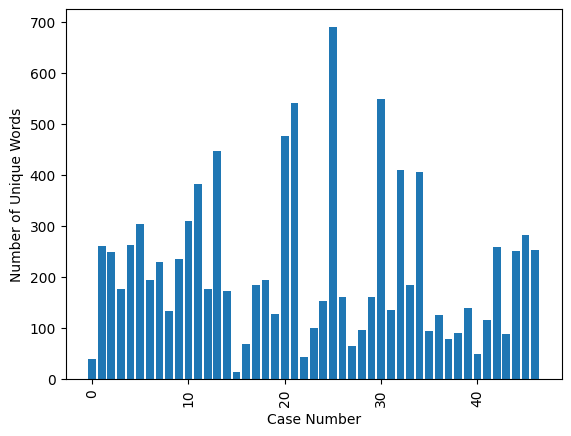

In [64]:
import matplotlib.pyplot as plt

# plot a bar chart using the index column as the x-axis and num_words as the y-axis
plt.bar(df_results.index, df_results["num_unique_words"])

# set the x-axis label
plt.xlabel("Case Number")

# set the y-axis label
plt.ylabel("Number of Unique Words")

# rotate the x-axis labels for readability
plt.xticks(rotation=90)

# display the plot
plt.show()

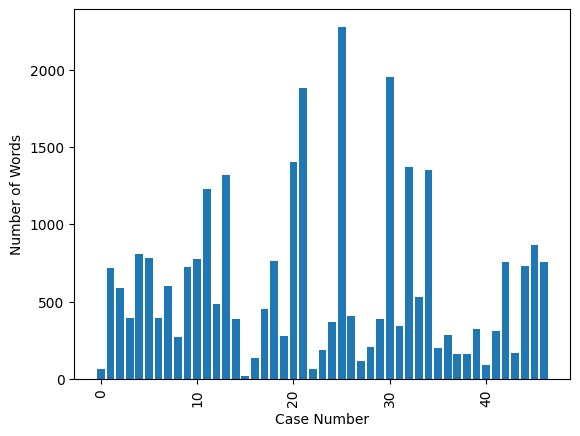

In [65]:
# plot a bar chart using the index column as the x-axis and num_words as the y-axis
plt.bar(df_results.index, df_results["num_words"])

# set the x-axis label
plt.xlabel("Case Number")

# set the y-axis label
plt.ylabel("Number of Words")

# rotate the x-axis labels for readability
plt.xticks(rotation=90)

# display the plot
plt.show()

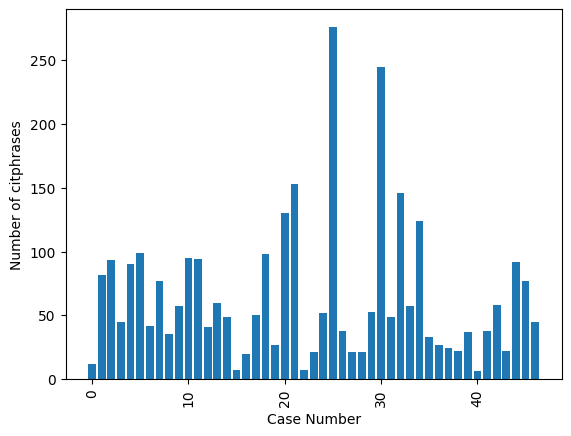

In [66]:
# plot a bar chart using the index column as the x-axis and num_words as the y-axis
plt.bar(df_results.index, df_results["num_citphrases"])

# set the x-axis label
plt.xlabel("Case Number")

# set the y-axis label
plt.ylabel("Number of citphrases")

# rotate the x-axis labels for readability
plt.xticks(rotation=90)

# display the plot
plt.show()

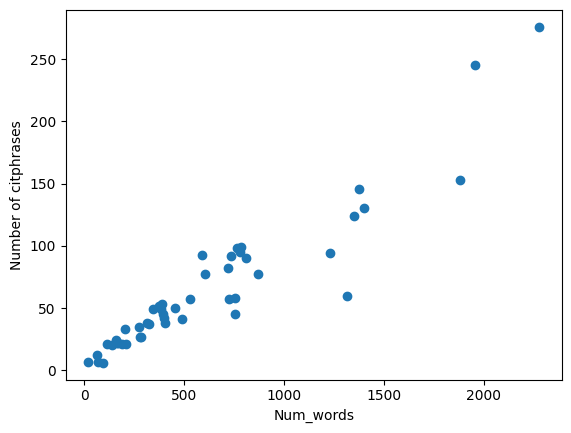

In [67]:
plt.scatter(x=df_results['num_words'], y=df_results["num_citphrases"])

# set the x-axis label
plt.xlabel("Num_words")

# set the y-axis label
plt.ylabel("Number of citphrases")

plt.show()

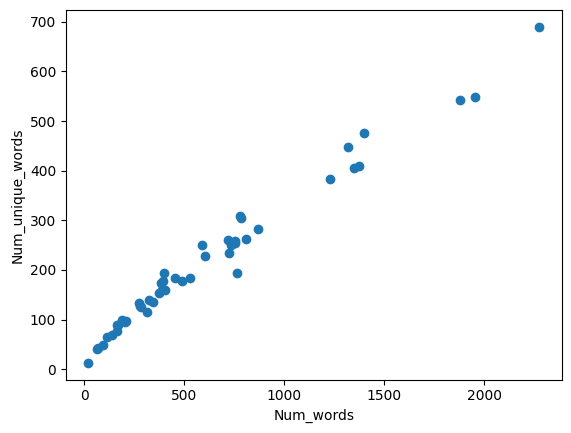

In [68]:
plt.scatter(x=df_results['num_words'], y=df_results["num_unique_words"])

# set the x-axis label
plt.xlabel("Num_words")

# set the y-axis label
plt.ylabel("Num_unique_words")

plt.show()

In [69]:
from google.colab.data_table import DataTable
DataTable.max_columns = 23

df_results.describe()

,num_words,num_unique_words,num_citphrases,sumbasic_citphrases_time,kl_div_citphrases_time,textrank_citphrases_time,bert_citphrases_time,nnse_citphrases_time,sumbasic_rouge1,sumbasic_rouge2,...,bert_rougeL,bert_rougeLsum,textrank_rouge1,textrank_rouge2,textrank_rougeL,textrank_rougeLsum,nnse_rouge1,nnse_rouge2,nnse_rougeL,nnse_rougeLsum
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,614.680851,216.148936,64.829787,0.030851,0.144255,0.324255,31.147234,28.838511,0.160872,0.044210,...,0.156071,0.156071,0.157409,0.033381,0.128529,0.128529,0.147847,0.025173,0.112601,0.112601
std,527.235411,149.382640,55.574595,0.039553,0.192125,0.683093,25.792858,53.873049,0.108776,0.065786,...,0.071254,0.071254,0.102453,0.049229,0.075008,0.075008,0.103183,0.056274,0.075666,0.075666
min,20.000000,13.000000,6.000000,0.000000,0.010000,0.000000,1.300000,0.480000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,241.500000,107.500000,27.000000,0.010000,0.040000,0.040000,12.630000,3.495000,0.085455,0.000000,...,0.104580,0.104580,0.077677,0.000000,0.073864,0.073864,0.062561,0.000000,0.060606,0.060606
50%,406.000000,177.000000,49.000000,0.020000,0.100000,0.110000,20.340000,9.370000,0.137931,0.014815,...,0.153846,0.153846,0.153846,0.000000,0.125000,0.125000,0.142857,0.000000,0.097196,0.097196
75%,771.000000,261.500000,91.000000,0.030000,0.200000,0.290000,41.975000,23.620000,0.215961,0.048200,...,0.211141,0.211141,0.217494,0.048810,0.179144,0.179144,0.204029,0.026637,0.148454,0.148454
max,2276.000000,690.000000,276.000000,0.220000,1.250000,3.970000,113.780000,292.720000,0.459770,0.285714,...,0.303030,0.303030,0.455224,0.195489,0.312500,0.312500,0.500000,0.280576,0.321429,0.321429


In [70]:
df_results_grouped = df_results.mean()

<ipython-input-70-c9e1ae9ece72>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_results_grouped = df_results.mean()


In [71]:
df_results_grouped

num_words                   614.680851
num_unique_words            216.148936
num_citphrases               64.829787
sumbasic_citphrases_time      0.030851
kl_div_citphrases_time        0.144255
textrank_citphrases_time      0.324255
bert_citphrases_time         31.147234
nnse_citphrases_time         28.838511
sumbasic_rouge1               0.160872
sumbasic_rouge2               0.044210
sumbasic_rougeL               0.131801
sumbasic_rougeLsum            0.131801
kl_rouge1                     0.088020
kl_rouge2                     0.021195
kl_rougeL                     0.064404
kl_rougeLsum                  0.064404
bert_rouge1                   0.242347
bert_rouge2                   0.061921
bert_rougeL                   0.156071
bert_rougeLsum                0.156071
textrank_rouge1               0.157409
textrank_rouge2               0.033381
textrank_rougeL               0.128529
textrank_rougeLsum            0.128529
nnse_rouge1                   0.147847
nnse_rouge2              

In [72]:
df_results_cols = df_results.loc[:, ['sumbasic_citphrases_time', 'kl_div_citphrases_time', 'textrank_citphrases_time', 'bert_citphrases_time', 'nnse_citphrases_time']]

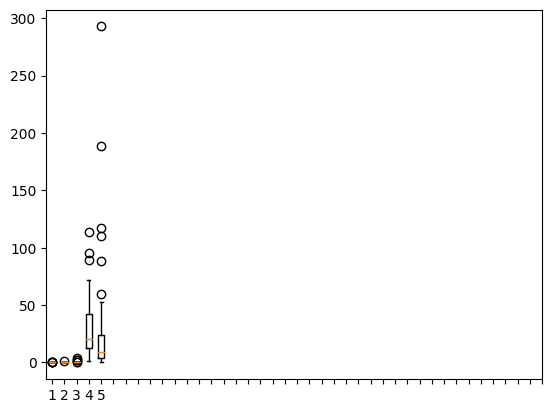

In [74]:
plt.boxplot(df_results_cols.values)
plt.xticks(range(1, len(df.columns) + 1))
plt.show()

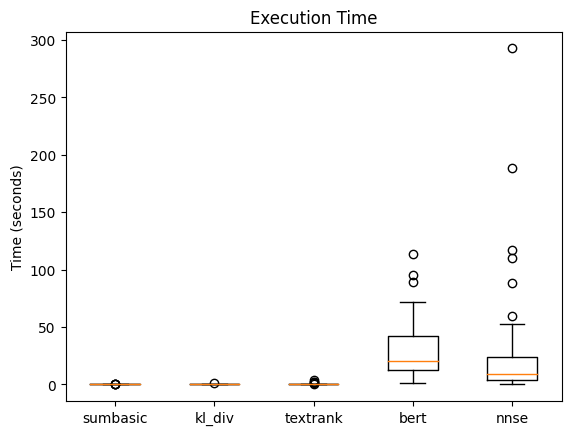

In [75]:
# select 5 columns
df_results_cols = df_results.loc[:, ['sumbasic_citphrases_time', 'kl_div_citphrases_time', 'textrank_citphrases_time', 'bert_citphrases_time', 'nnse_citphrases_time']]

# create a boxplot
plt.boxplot(df_results_cols.values)
plt.xticks(range(1, len(df_results_cols.columns) + 1), ['sumbasic', 'kl_div', 'textrank', 'bert', 'nnse'])
plt.title('Execution Time')
plt.ylabel('Time (seconds)')
plt.show()

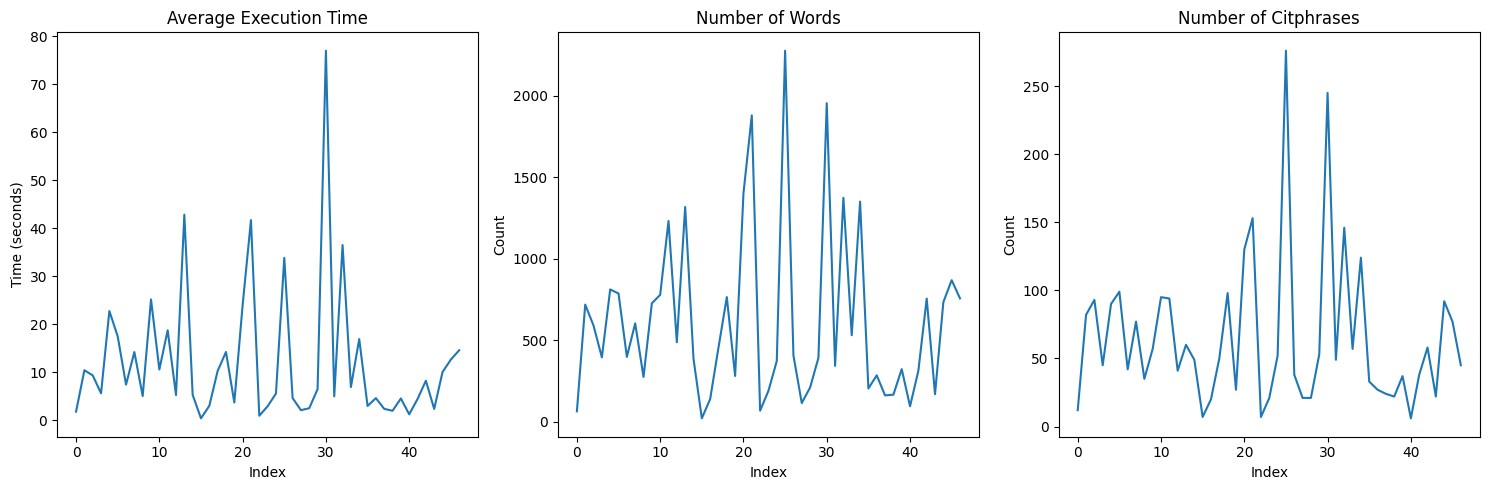

In [76]:

# select 5 columns, number of words, and number of citphrases
df_results_cols = df_results.loc[:, ['sumbasic_citphrases_time', 'kl_div_citphrases_time', 'textrank_citphrases_time', 'bert_citphrases_time', 'nnse_citphrases_time']]
df_results_words = df_results['num_words']
df_results_citphrases = df_results['num_citphrases']

# calculate the average row-wise
df_results_avg = df_results_cols.mean(axis=1)

# create three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# plot for average execution time
axs[0].plot(df_results_avg)
axs[0].set_title('Average Execution Time')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Time (seconds)')

# plot for number of words
axs[1].plot(df_results_words)
axs[1].set_title('Number of Words')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Count')

# plot for number of citphrases
axs[2].plot(df_results_citphrases)
axs[2].set_title('Number of Citphrases')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Count')

# display the plots
plt.tight_layout()
plt.show()

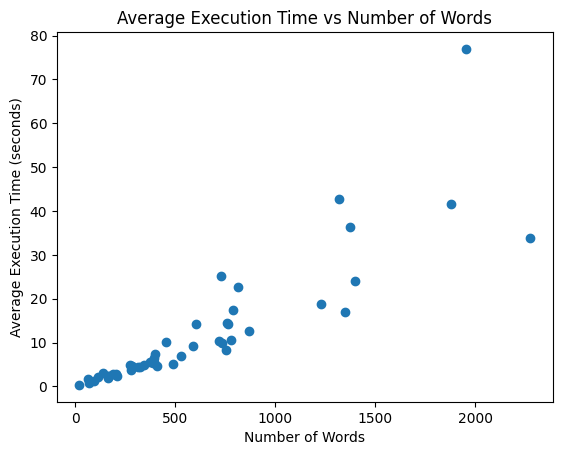

In [77]:
# select 5 columns and number of words
df_results_cols = df_results.loc[:, ['sumbasic_citphrases_time', 'kl_div_citphrases_time', 'textrank_citphrases_time', 'bert_citphrases_time', 'nnse_citphrases_time']]
df_results_words = df_results['num_words']

# calculate the average row-wise
df_results_avg = df_results_cols.mean(axis=1)

# create a scatter plot
plt.scatter(df_results_words, df_results_avg)
plt.title('Average Execution Time vs Number of Words')
plt.xlabel('Number of Words')
plt.ylabel('Average Execution Time (seconds)')

# display the plot
plt.show()

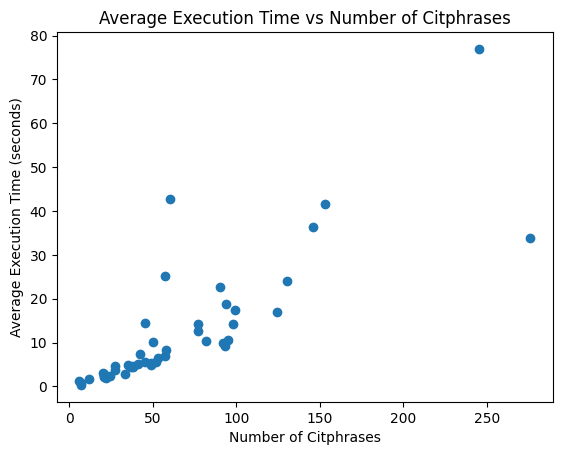

In [79]:
# select 5 columns and number of words
df_results_cols = df_results.loc[:, ['sumbasic_citphrases_time', 'kl_div_citphrases_time', 'textrank_citphrases_time', 'bert_citphrases_time', 'nnse_citphrases_time']]
df_results_words = df_results['num_citphrases']

# calculate the average row-wise
df_results_avg = df_results_cols.mean(axis=1)

# create a scatter plot
plt.scatter(df_results_words, df_results_avg)
plt.title('Average Execution Time vs Number of Citphrases')
plt.xlabel('Number of Citphrases')
plt.ylabel('Average Execution Time (seconds)')

# display the plot
plt.show()